# Introduction

Welcome to this lab!
At this lab, we will learn:
1. How to build a graph from a file or create a simple graph by ourself
2. Implement DeepWalk in the simplest way based on the paper [DeepWalk](https://arxiv.org/pdf/1403.6652.pdf). You can implement your own code or study some packages already made. I recommend reading Karateclub framwork, which is well-known for Unsupervised Learning on Graphs

# Exercise

## Download data and install packages

In [1]:
!gdown --id "1vqsjGzGZnpCEgHliEsVmAvzm9_1h3L-Y&export=download"
!unrar x -Y "/content/lab1.rar" -d "/content/"

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1vqsjGzGZnpCEgHliEsVmAvzm9_1h3L-Y&export=download
To: /content/lab1.rar
100% 50.0k/50.0k [00:00<00:00, 10.0MB/s]

UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/lab1.rar

Extracting  /content/lab1_big_edgelist.txt                                99%  OK 
Extracting  /content/lab1_small_edgelist.txt                             100%  OK 
All OK


## Build a graph

In [2]:
import networkx as nx
import numpy as np
import torch

### TO DO: Create graphs

Create a graph from the file: "lab1_small_edgelist.txt"

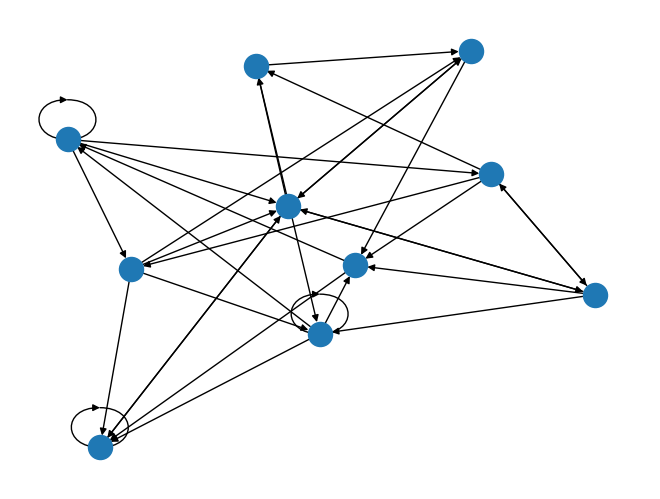

In [3]:
# TO DO: Create a graph from the file: "lab1_small_edgelist.txt"
G1 = nx.read_edgelist('lab1_small_edgelist.txt',create_using=nx.DiGraph(),nodetype=None,data=[('weight',int)])
nx.draw(G1)

Create a graph by generating nodes and edges.

In [23]:
# TO DO: Create a graph by generating nodes and edges.
G2_info = torch.randint(0, 2, (10, 10))

def build_graph(info):
  graph = nx.DiGraph()
  for i in range(len(info)):
    for j in range(len(info[1])):
      if(info[i][j] == 1):
        graph.add_edge(i, j)
      if(i == j):
        graph.add_edge(i, j)
  return graph

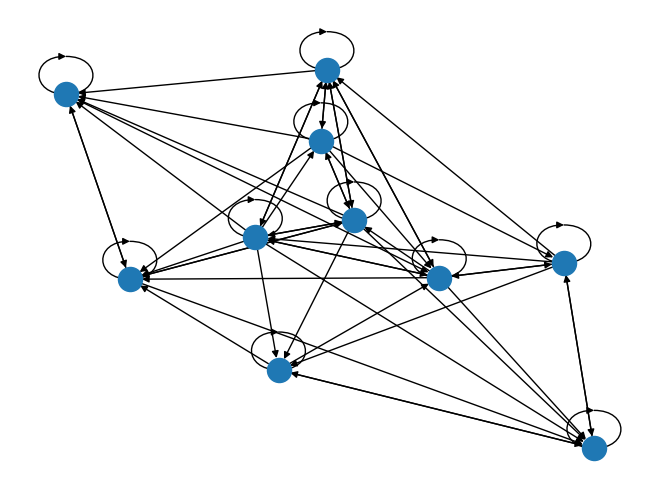

In [24]:
G2 = build_graph(G2_info)
nx.draw(G2)

## Implement DeepWalk

### Packages: Import necessary packages

In [5]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 63.0 MB/s eta 0:00:00


In [15]:
import networkx as nx
from joblib import Parallel, delayed
import random
import itertools
import numpy as np
from gensim.models import Word2Vec

### Utils: Processing data

In [25]:
def partition_num(num, workers):
    if num % workers == 0:
        return [num//workers]*workers
    else:
        return [num//workers]*workers + [num % workers]

### TO DO: Implement DeepWalk

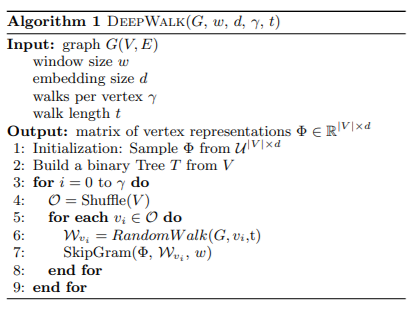

In [26]:
# Please implement your code here.
# 1. Try to build your own code
# 2. Try to use class RandomWalk built in the KarateClub framework (used in homework's solution)
class RandomWalker:
  def __init__(self, G, num_walks, walk_length):
      """
      :param G: Graph
      :param num_walks: a number of walks per vertex
      :param walk_length: Length of a walk. Each walk is considered as a sentence
      """
      self.G = G
      self.num_walks = num_walks
      self.walk_length = walk_length

  def deep_walk(self, start_node):
    walk = [start_node]
    while len(walk) < self.walk_length:
      cur = walk[-1]
      cur_nbrs = list(self.G.neighbors(cur))
      if len(cur_nbrs) > 0:
        walk.append(random.choice(cur_nbrs))
      else:
        break
    return walk

  # INFORMATION EXTRACTOR
  def _simulate_walks(self):
      # TO DO: Create walks
      walks = []
      nodes = list(self.G.nodes())
      for _ in range(self.num_walks):
        random.shuffle(nodes)
        for node in nodes:
          walks.append(self.deep_walk(node))
      return walks

  def simulate_walks(self, workers=1, verbose=0):
      G = self.G
      nodes = list(G.nodes())
      results = Parallel(n_jobs=workers, verbose=verbose)(
          delayed(self._simulate_walks)() for num in
          partition_num(self.num_walks, workers))
      walks = list(itertools.chain(*results))
      return walks

In [27]:
class DeepWalk:
    def __init__(self, graph, walk_length, num_walks):

        self.graph = graph
        self.w2v_model = None
        self._embeddings = {}

        self.walker = RandomWalker(graph, num_walks=num_walks, walk_length=walk_length)
        self.walks = self.walker.simulate_walks()


    def train(self, embed_size=128, window_size=5, workers=1, iter=5, **kwargs):

        kwargs["sentences"] = self.walks
        kwargs["min_count"] = kwargs.get("min_count", 0)
        #kwargs["size"] = embed_size
        kwargs["sg"] = 1  # skip gram
        kwargs["hs"] = 1  # deepwalk use Hierarchical Softmax
        kwargs["workers"] = workers
        kwargs["window"] = window_size
        #kwargs["iter"] = iter

        print("Learning embedding vectors...")
        model = Word2Vec(**kwargs) # Pay attention here
        print("Learning embedding vectors done!")

        self.w2v_model = model
        return model

    def get_embeddings(self,):
        if self.w2v_model is None:
            print("model not train")
            return {}

        self._embeddings = {}
        for word in self.graph.nodes():
            self._embeddings[word] = self.w2v_model.wv[word]

        return self._embeddings

### Run graph embedding

In [28]:
G = nx.read_edgelist('lab1_big_edgelist.txt',create_using=nx.DiGraph(),nodetype=None,data=[('weight',int)])# Read graph
model = DeepWalk(G,walk_length=10,num_walks=80)#init model
model.train(window_size=5,iter=3)# train model
embeddings = model.get_embeddings()# get embedding vectors

Learning embedding vectors...


Learning embedding vectors done!


# Questions

Did you see that we use the function "Word2vec" as the primary function to implement the DeepWalk algorithm?

The reason is that DeepWalk is based on the idea of Word2vec. As a result, all we need is packed in the implementation of Word2vec. Within a short amount of time, we couldn't go through all the code.

This is your homework. The details will be shown in the file "Lab3 - Homeworks".

Please take a look at [this file](https://github.com/RaRe-Technologies/gensim/blob/develop/gensim/models/word2vec.py) for more details.